In [ ]:
#| hide
!pip install -Uqq nixtla datasetsforecast utilsforecast

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Long-horizon forecasting

Long-horizon forecasting refers to predictions far into the future, typically exceeding two seasonal periods. However, the exact definition of a 'long horizon' can vary based on the frequency of the data. For example, when dealing with hourly data, a forecast for three days into the future is considered long-horizon, as it covers 72 timestamps (calculated as 3 days × 24 hours/day). In the context of monthly data, a period exceeding two years would typically be classified as long-horizon forecasting. Similarly, for daily data, a forecast spanning more than two weeks falls into the long-horizon category.

Of course, forecasting over a long horizon comes with its challenges. The longer the forecast horizon, the greater the uncertainty in the predictions. It is also possible to have unknown factors come into play in the long-term that were not expected at the time of forecasting.

To tackle those challenges, use TimeGPT's specialized model for long-horizon forecasting by specifying `model='timegpt-1-long-horizon'` in your setup.

For a detailed step-by-step guide, follow this tutorial on long-horizon forecasting.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()    
    colab_badge('docs/tutorials/04_longhorizon')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/04_longhorizon.ipynb)

## 1. Import packages
First, we install and import the required packages and initialize the Nixtla client.

In [ ]:
from nixtla import NixtlaClient
from datasetsforecast.long_horizon import LongHorizon
from utilsforecast.losses import mae

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(
>         base_url="you azure ai endpoint",
>         api_key="your api_key"`
>)

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load the data

Let's load the ETTh1 dataset. This is a widely used dataset to evaluate models on their long-horizon forecasting capabalities. 

The ETTh1 dataset monitors an electricity transformer from a region of a province of China including oil temperature and variants of load (such as high useful load and high useless load) from July 2016 to July 2018 at an hourly frequency.

For this tutorial, let's only consider the oil temperature variation over time.

In [ ]:
Y_df, *_ = LongHorizon.load(directory='./', group='ETTh1')

Y_df.head()

100%|██████████| 314M/314M [00:52<00:00, 5.99MiB/s] 
INFO:datasetsforecast.utils:Successfully downloaded datasets.zip, 314116557, bytes.
INFO:datasetsforecast.utils:Decompressing zip file...
INFO:datasetsforecast.utils:Successfully decompressed longhorizon\datasets\datasets.zip


,unique_id,ds,y
0,OT,2016-07-01 00:00:00,1.460552
1,OT,2016-07-01 01:00:00,1.161527
2,OT,2016-07-01 02:00:00,1.161527
3,OT,2016-07-01 03:00:00,0.862611
4,OT,2016-07-01 04:00:00,0.525227


For this small experiment, let's set the horizon to 96 time steps (4 days into the future), and we will feed TimeGPT with a sequence of 42 days.

In [ ]:
test = Y_df[-96:]             # 96 = 4 days x 24h/day
input_seq = Y_df[-1104:-96]   # Gets a sequence of 1008 observations (1008 = 42 days * 24h/day)

## 3. Forecasting for long-horizon

Now, we are ready to use TimeGPT for long-horizon forecasting. Here, we need to set the `model` parameter to `"timegpt-1-long-horizon"`. This is the specialized model in TimeGPT that can handle such tasks.

In [ ]:
fcst_df = nixtla_client.forecast(
    df=input_seq,
    h=96,
    level=[90],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")` 

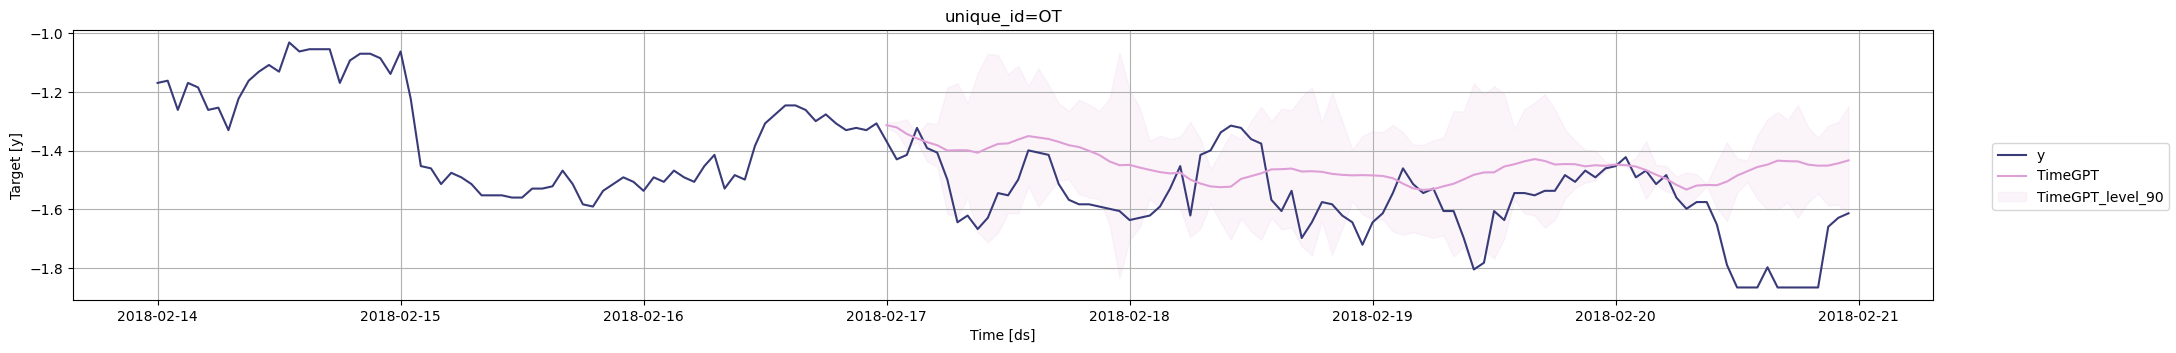

In [ ]:
nixtla_client.plot(Y_df[-168:], fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

## Evaluation

Let's now evaluate the performance of TimeGPT using the mean absolute error (MAE).

In [ ]:
test = test.copy()

test.loc[:, 'TimeGPT'] = fcst_df['TimeGPT'].values

In [ ]:
evaluation = mae(test, models=['TimeGPT'], id_col='unique_id', target_col='y')

print(evaluation)

  unique_id   TimeGPT
0        OT  0.145393


Here, TimeGPT achieves a MAE of 0.146.